In [1]:
# Load necessary libraries and tools...

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import math
import psycopg2 as psy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import pandas.io.sql as psql
%matplotlib inline


In [3]:
# Loading data from csv files...

In [4]:
cohort_1_w1w2 = pd.read_csv('/Users/cguy/kelstuff/ga_summer_2016/cohort_1_w1w2.csv')
cohort_1_w1w2.head()

/Users/cguy/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,9,10,11,12,16,20,23,26,29,30,31,32,33,36,38,39,40,41,43,44,45,46,51,52,53,56,59,60,62,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,AcSuppSv,AgeMP,AmIAKN,Asian,Baseline,BlkAfrAm,BudgetSv,CareerSv,CurrFTE,...,Sex,SpecEdSv,St,StFCID,StFIPS,SubAbuse,TribeSv,Wave,Weight,White
0,0,0.0,17.0,0.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,0.0,AK,AK450290395006,2.0,Yes,0.0,Wave 1: Age 17 Baseline Survey,1.26,1.0
1,4,0.0,17.0,1.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,0.0,AK,AK450448396586,2.0,No,1.0,Wave 1: Age 17 Baseline Survey,1.36,0.0
2,10,0.0,17.0,0.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,0.0,AK,AK450540097503,2.0,No,0.0,Wave 1: Age 17 Baseline Survey,1.26,1.0
3,14,0.0,17.0,0.0,0.0,Yes,0.0,0.0,0.0,No,...,1.0,0.0,AK,AK450652098623,2.0,No,0.0,Wave 1: Age 17 Baseline Survey,3.31,1.0
4,17,0.0,17.0,1.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,1.0,AK,AK451448406587,2.0,No,1.0,Wave 1: Age 17 Baseline Survey,1.36,0.0


In [5]:
cohort_1_w1w2.columns

Index([u'Unnamed: 0', u'AcSuppSv', u'AgeMP', u'AmIAKN', u'Asian', u'Baseline',
       u'BlkAfrAm', u'BudgetSv', u'CareerSv', u'CurrFTE', u'CurrPTE',
       u'CurrenRoll', u'DOB', u'DelinqntSv', u'EdLevlSv', u'EducFinaSv',
       u'Elig19', u'EmplyTrSv', u'FCStatSv', u'FY', u'FY11Cohort',
       u'FamSuppSv', u'HawaiiPI', u'HighEdCert', u'HisOrgin', u'HlthEdSv',
       u'Homeless', u'HousEdSv', u'ILNAsv', u'InSample', u'Incarc',
       u'Medicaid', u'MedicalIn', u'MentlHlthIn', u'MentorSv', u'Num_services',
       u'OthrFinAs', u'OthrFinaSv', u'OthrHlthIn', u'OutcmDte', u'OutcmFCS',
       u'OutcmRpt', u'PSEdSuppSv', u'PrescripIn', u'PubFinAs', u'PubFoodAs',
       u'PubHousAs', u'Race', u'RaceDcln', u'RaceEthn', u'RaceUnkn',
       u'RepDate_outcomes', u'RepDate_services', u'Responded', u'RmBrdFASv',
       u'SILsv', u'SampleState', u'Sex', u'SpecEdSv', u'St', u'StFCID',
       u'StFIPS', u'SubAbuse', u'TribeSv', u'Wave', u'Weight', u'White'],
      dtype='object')

# 1) Preprocess data and separate target variables from feature variables and demographics

In [6]:
# Seperate dataframe into feature vars and target vars

targets = cohort_1_w1w2[['PubFoodAs','PubHousAs','OthrFinAs','HighEdCert','CurrFTE','CurrPTE', \
                     'PubFinAs','CurrenRoll','PrescripIn','Homeless','SubAbuse','Incarc','Medicaid','OthrHlthIn','MedicalIn','MentlHlthIn', 'Wave']]


features = cohort_1_w1w2[['ILNAsv','AcSuppSv','PSEdSuppSv','CareerSv','EmplyTrSv','BudgetSv','HousEdSv','HlthEdSv',\
                     'FamSuppSv','MentorSv','SILsv','RmBrdFASv','EducFinaSv','OthrFinaSv','St','DelinqntSv','Wave']]

demographics = cohort_1_w1w2[['St','DelinqntSv','Sex','Race','TribeSv','EdLevlSv','SpecEdSv','RaceEthn','AgeMP','Wave']]
demographics_W1 = demographics[demographics.Wave == "Wave 1: Age 17 Baseline Survey"]
demographics_W2 = demographics[demographics.Wave == "Wave 2: Age 19 Followup"]

In [7]:
# # Create column for number of services received

services_count = features.T
services_count = services_count.drop('Wave')
services_count = services_count.drop('St')
services_count = services_count.drop('DelinqntSv')


features['Num_services'] = (services_count == 1).sum()
features.head(10)

/Users/cguy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,St,DelinqntSv,Wave,Num_services
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,2
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AK,0.0,Wave 1: Age 17 Baseline Survey,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,3
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AK,0.0,Wave 1: Age 17 Baseline Survey,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,2
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,1
6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,4
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,2
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,1
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,2


In [8]:
# Let's focus on just W2 targets and features

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

features_2 = features.copy()

features_w2 = features_2[features_2.Wave == "Wave 2: Age 19 Followup"]
features_w2 = features_w2.drop('Wave', axis = 1)

features_w2['St'] = le.fit_transform(features_w2['St'])

features_w2.head()

,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,St,DelinqntSv,Num_services
7328,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,2
7329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
7330,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0,3
7331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
7332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,2


In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

targets_w2_ = targets[targets.Wave == "Wave 2: Age 19 Followup"]
targets_w2_ = targets_w2_.drop('Wave', axis = 1)


targets_w2 = targets_w2_.copy()

for column in targets_w2:
    targets_w2[column] = le.fit_transform(targets_w2[column])
targets_w2.head()

/Users/cguy/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


,PubFoodAs,PubHousAs,OthrFinAs,HighEdCert,CurrFTE,CurrPTE,PubFinAs,CurrenRoll,PrescripIn,Homeless,SubAbuse,Incarc,Medicaid,OthrHlthIn,MedicalIn,MentlHlthIn
7328,4,2,2,7,2,2,2,2,4,3,2,2,4,4,4,4
7329,2,2,2,5,2,2,2,2,4,2,2,2,3,4,4,4
7330,4,2,2,5,2,2,2,3,4,2,3,3,4,4,4,4
7331,4,2,2,5,2,3,2,2,4,3,2,2,4,4,4,4
7332,4,2,2,5,3,2,2,2,4,3,2,2,4,5,2,4


# 2) PCA over target (y) variables

In [10]:
# y-correlations

y_corr = np.corrcoef(targets_w2.values.T)
targets_w2.corr()

,PubFoodAs,PubHousAs,OthrFinAs,HighEdCert,CurrFTE,CurrPTE,PubFinAs,CurrenRoll,PrescripIn,Homeless,SubAbuse,Incarc,Medicaid,OthrHlthIn,MedicalIn,MentlHlthIn
PubFoodAs,1.000000,0.886919,0.870077,0.714728,0.869874,0.856714,0.888024,0.858523,0.892729,0.872588,0.873892,0.858727,0.887538,0.868990,0.891632,0.889446
PubHousAs,0.886919,1.000000,0.895309,0.712087,0.890962,0.882024,0.929199,0.894590,0.914980,0.872408,0.893191,0.872126,0.904352,0.885868,0.913547,0.913284
OthrFinAs,0.870077,0.895309,1.000000,0.738008,0.924232,0.915193,0.884853,0.914356,0.941550,0.916054,0.928380,0.915808,0.929921,0.922400,0.940742,0.938488
HighEdCert,0.714728,0.712087,0.738008,1.000000,0.723115,0.715918,0.709558,0.757422,0.751611,0.748057,0.743454,0.740237,0.748196,0.732575,0.748967,0.749937
CurrFTE,0.869874,0.890962,0.924232,0.723115,1.000000,0.911457,0.883162,0.907216,0.952491,0.921979,0.932155,0.920066,0.925983,0.929696,0.953366,0.950071
CurrPTE,0.856714,0.882024,0.915193,0.715918,0.911457,1.000000,0.872666,0.902568,0.933062,0.904285,0.914444,0.899056,0.917177,0.909664,0.932853,0.928115
PubFinAs,0.888024,0.929199,0.884853,0.709558,0.883162,0.872666,1.000000,0.884991,0.905017,0.868806,0.883262,0.862984,0.899117,0.880122,0.902910,0.901851
CurrenRoll,0.858523,0.894590,0.914356,0.757422,0.907216,0.902568,0.884991,1.000000,0.934347,0.892984,0.909427,0.894658,0.927136,0.913728,0.933575,0.930470
PrescripIn,0.892729,0.914980,0.941550,0.751611,0.952491,0.933062,0.905017,0.934347,1.000000,0.935910,0.947686,0.936397,0.945660,0.956237,0.985035,0.983358
Homeless,0.872588,0.872408,0.916054,0.748057,0.921979,0.904285,0.868806,0.892984,0.935910,1.000000,0.932703,0.927434,0.915469,0.918826,0.936868,0.932474


In [11]:
# Obtaining eigenvalues and eigenvectors for PCA

eig_vals, eig_vecs = np.linalg.eig(y_corr)
print eig_vals
print eig_vecs


[  1.44077983e+01   4.00291671e-01   2.49372515e-01   1.45369332e-01
   1.36106660e-02   1.97807403e-02   1.11188252e-01   1.01881933e-01
   8.98588242e-02   5.12413705e-02   5.29265812e-02   6.29249842e-02
   7.76505095e-02   7.66646631e-02   6.77224314e-02   7.17172285e-02]
[[-0.24274627 -0.02715446  0.48993157 -0.65771877  0.00240736 -0.01172185
   0.46487323 -0.03573324  0.10888298 -0.0696121  -0.02047043  0.04894277
   0.08252407 -0.14119096  0.06212393 -0.00790653]
 [-0.24772108 -0.0904995   0.46997139  0.22998895 -0.00706364 -0.00368329
  -0.32556906  0.00594446 -0.06487427 -0.12363542  0.08107211 -0.20789057
   0.08573253 -0.35392307 -0.59028161  0.01589096]
 [-0.25326292 -0.05094828 -0.09079979  0.08714081  0.00440117  0.00648906
  -0.00317517 -0.20997205  0.26286916 -0.02442725  0.00803815  0.29862809
  -0.76787696 -0.34366885  0.04008936 -0.07052322]
 [-0.20786823  0.96888389  0.02170922  0.0271264   0.00234494  0.00331329
  -0.01963713 -0.00298085 -0.1137424  -0.01743689 -0

In [12]:
# Obtaining cumulative explained variance

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print cum_var_exp

[  90.04873937   92.55056231   94.10914053   95.01769885   95.71262542
   96.34938751   96.91100516   97.39632084   97.87547499   98.32370766
   98.74697286   99.14025401   99.47104514   99.79130371   99.91493334
  100.        ]


In [13]:
# From output of cell above, we can see 
# that the first two principal components explain 92.6% of the variance in the target variables

In [14]:
# Obtaining eigenpairs...

value_vector_pairs = [[eig_vals[i], eig_vecs[:,i]] for i in range(len(eig_vals))]
value_vector_pairs.sort(reverse=True)

In [15]:
# Transforming eigen data to obtain 2d PCA projection matrix in order to plot principal components

weight_2d_projection = np.hstack((value_vector_pairs[0][1].reshape(eig_vecs.shape[1],1),
                                  value_vector_pairs[1][1].reshape(eig_vecs.shape[1],1)))

print 'Weight data 2d PCA projection matrix:\n', weight_2d_projection

Weight data 2d PCA projection matrix:
[[-0.24274627 -0.02715446]
 [-0.24772108 -0.0904995 ]
 [-0.25326292 -0.05094828]
 [-0.20786823  0.96888389]
 [-0.25368894 -0.10275778]
 [-0.25015934 -0.09435716]
 [-0.24587591 -0.08183761]
 [-0.25109508  0.03088238]
 [-0.25922666 -0.06640597]
 [-0.25185455 -0.00354776]
 [-0.25458118 -0.04397959]
 [-0.25145182 -0.02278282]
 [-0.25487988 -0.03453333]
 [-0.25380483 -0.07288633]
 [-0.2590987  -0.07223928]
 [-0.2583296  -0.0634675 ]]


In [16]:
Z = targets_w2.dot(weight_2d_projection)


### PC1 vs PC2

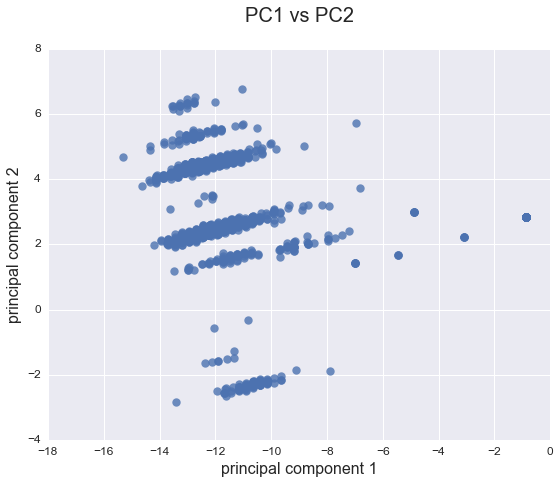

In [17]:
fig = plt.figure(figsize=(9,7))

ax = fig.gca()
ax = sns.regplot(Z.iloc[:,0], Z.iloc[:,1],
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=16)
ax.set_ylabel('principal component 2', fontsize=16)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs PC2\n', fontsize=20)

plt.show()

In [18]:
# Will now transform data so that PC1 and PC2 can be plotted with individual target variables...
# Need to do this in order to see which variables are more likely part of the principal components...

targets_2 = targets_w2

targets_pcs = targets_2.copy

targets_pcs = (targets_2 - targets_2.mean()) / targets_2.std()

targets_pcs['PC1'] = Z.iloc[:,0]
targets_pcs['PC2'] = Z.iloc[:,1]

In [19]:
targets_pcs = pd.melt(targets_pcs, id_vars=['PC1','PC2'])


In [20]:
targets_pcs.head()

,PC1,PC2,variable,value
0,-12.338658,4.512236,PubFoodAs,1.551348
1,-10.930694,2.666858,PubFoodAs,0.199028
2,-12.428195,2.542136,PubFoodAs,1.551348
3,-12.173080,2.480111,PubFoodAs,1.551348
4,-11.912217,2.543302,PubFoodAs,1.551348


### PC1 vs Target Variables

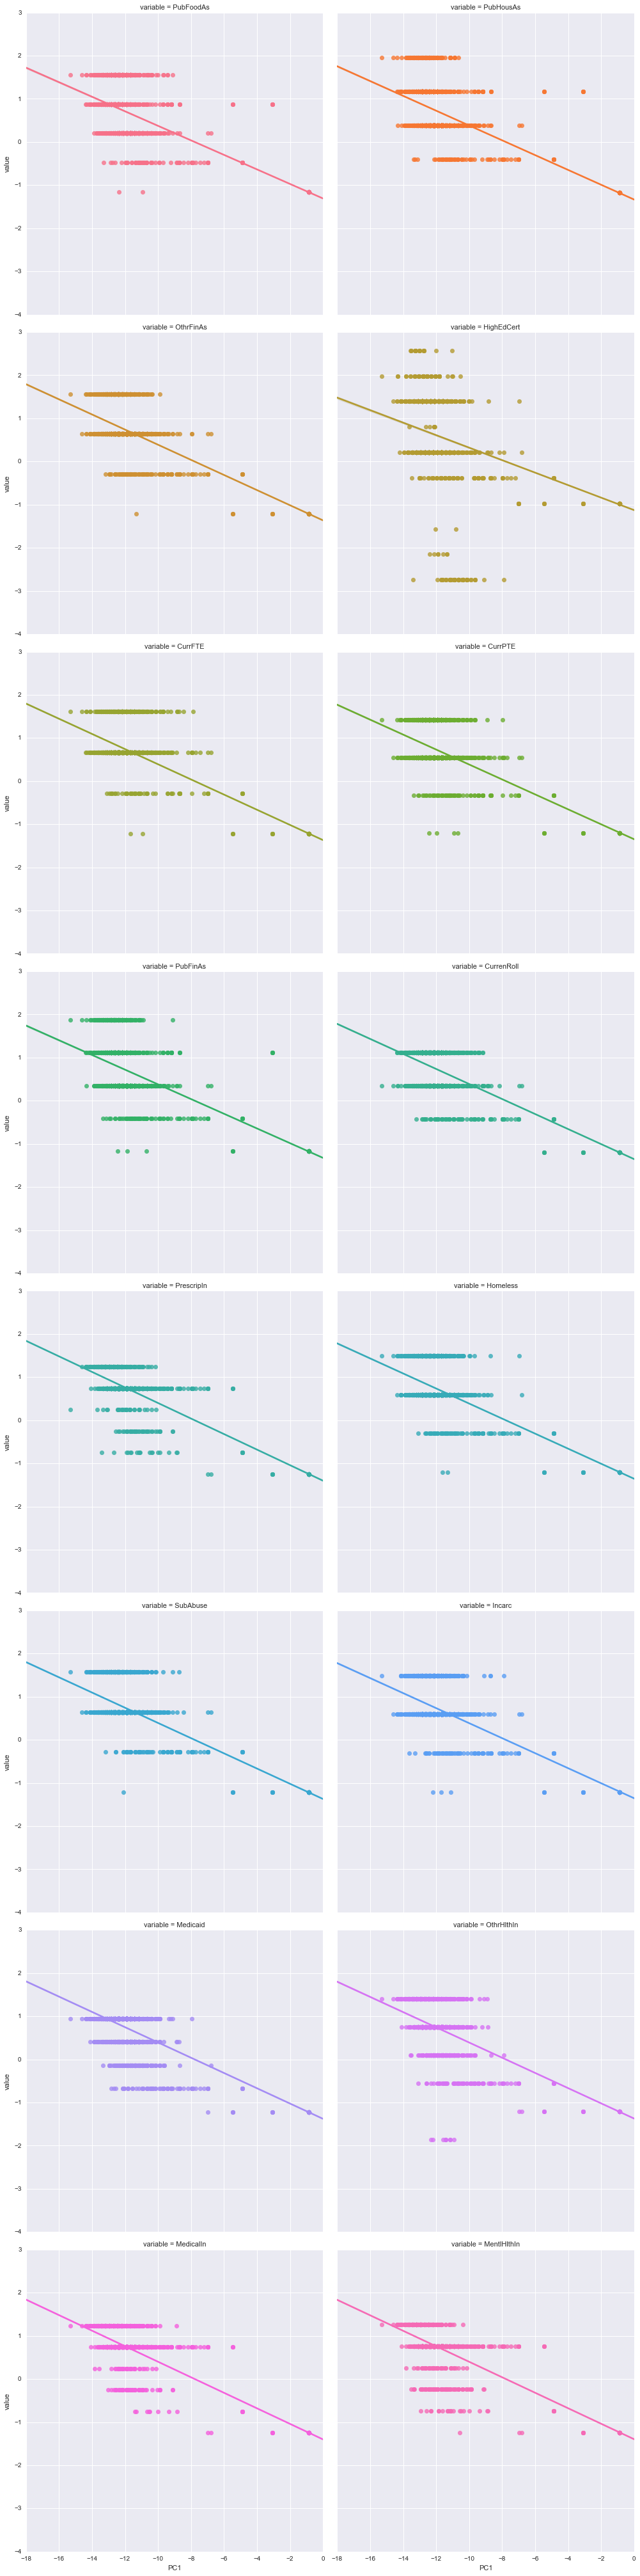

In [21]:
pc1 = sns.lmplot(x="PC1", y="value", col="variable", hue="variable", 
                 data=targets_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

### PC2 vs Target Variables

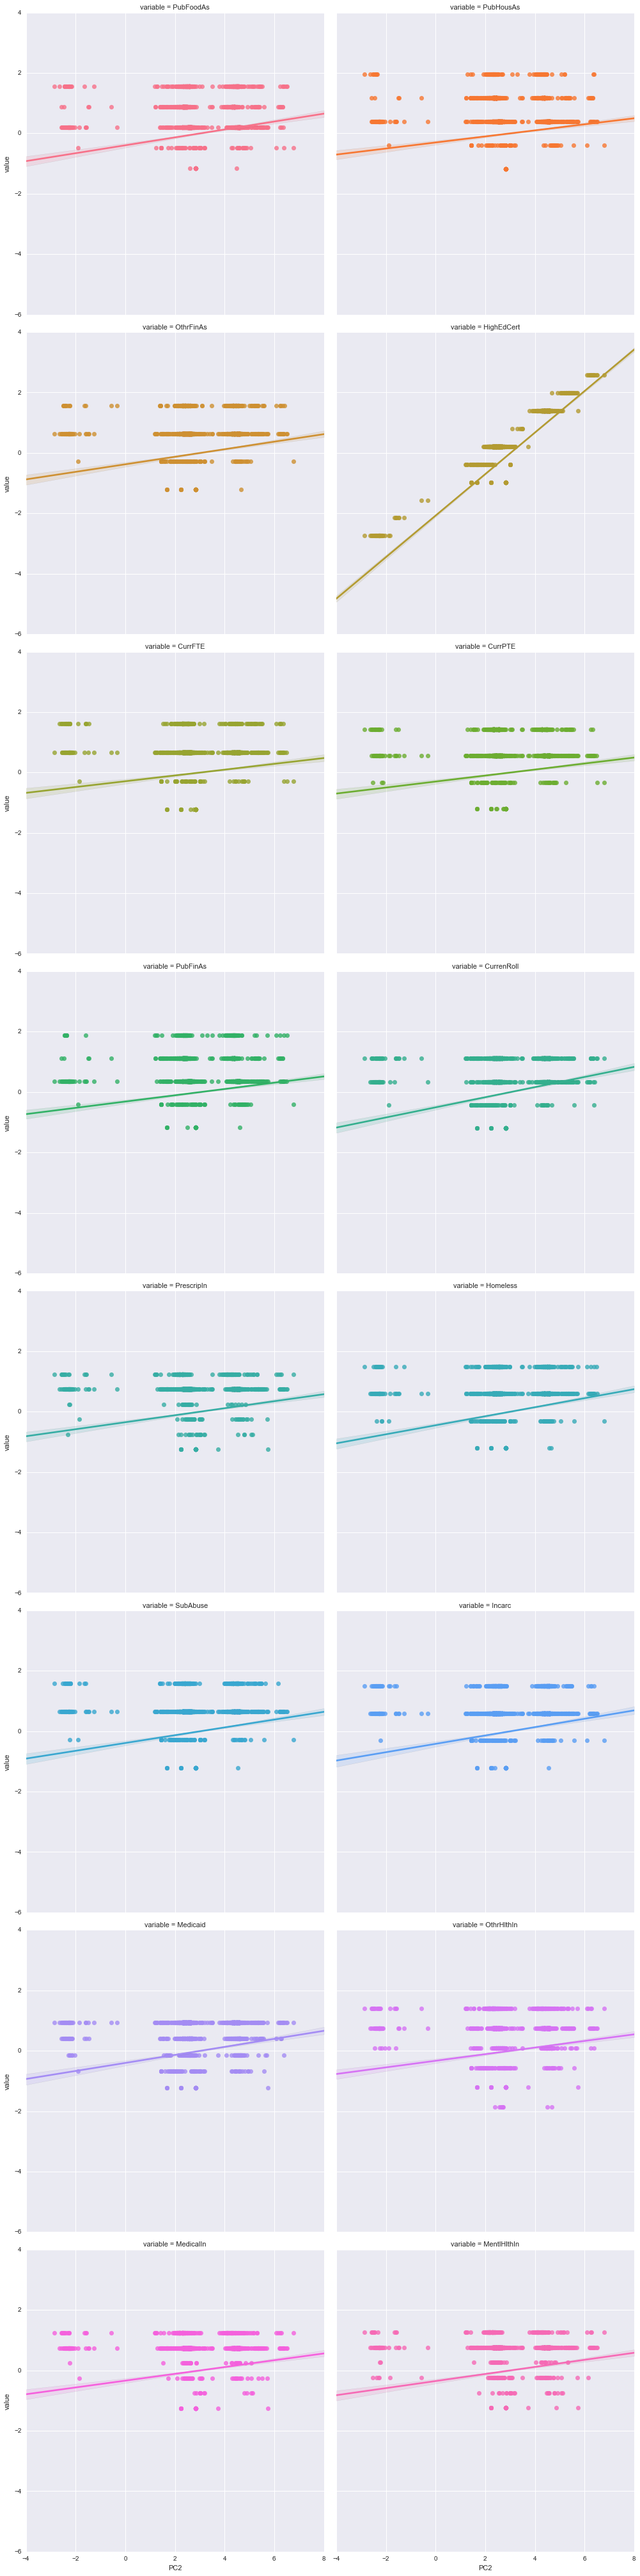

In [22]:
pc2 = sns.lmplot(x="PC2", y="value", col="variable", hue="variable", 
                 data=targets_pcs, col_wrap=2, size=7, scatter_kws={'s':50})


In [23]:
# From the PCAs so far, can see that HighEdCert should be the target variable for this project

### PC1 vs PC2 WITH LABELS

In [24]:
from sklearn.decomposition import PCA 

pcask = PCA(n_components=2)
print pcask.fit(targets_w2).components_ # See the eigenvectors
yPC = pcask.fit_transform(targets_w2) # Use the eigenvectors to transform xStand onto new axes

PCdf = pd.DataFrame(yPC, columns=['PC1','PC2'])

targets_2 = targets_w2

target_pca = targets_2.join(PCdf, on=None, how='left')

[[-0.24132997 -0.2118988  -0.18364068 -0.23836743 -0.18045001 -0.19166072
  -0.21702861 -0.21897984 -0.3510533  -0.18732218 -0.18280779 -0.18748198
  -0.31822139 -0.26241788 -0.35217689 -0.34772606]
 [-0.02747461 -0.06436903 -0.03683873  0.96596851 -0.06868541 -0.06498501
  -0.05865357  0.00950304 -0.10833398 -0.01090734 -0.03362602 -0.02332586
  -0.05565659 -0.08583937 -0.11526432 -0.10438531]]


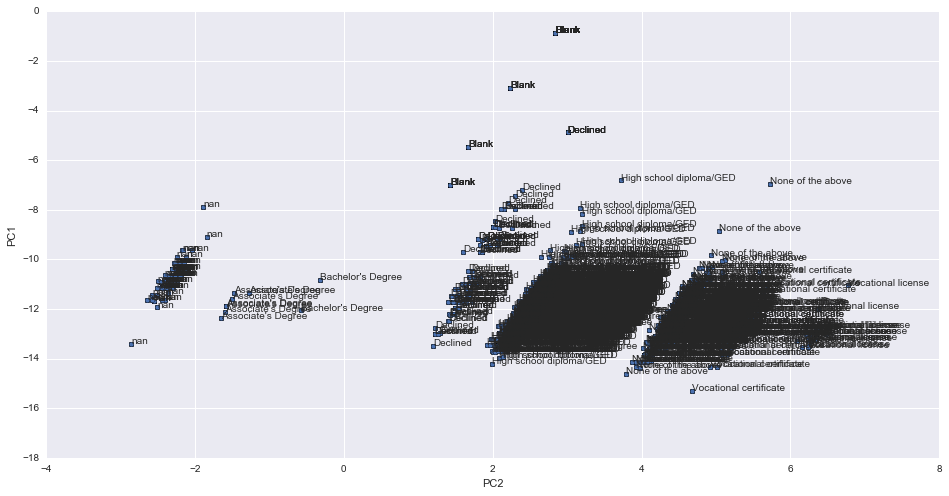

In [25]:
graph = targets_pcs.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, target in enumerate(targets_w2_['HighEdCert']):
    graph.annotate(target, (targets_pcs.iloc[i].PC2, targets_pcs.iloc[i].PC1))

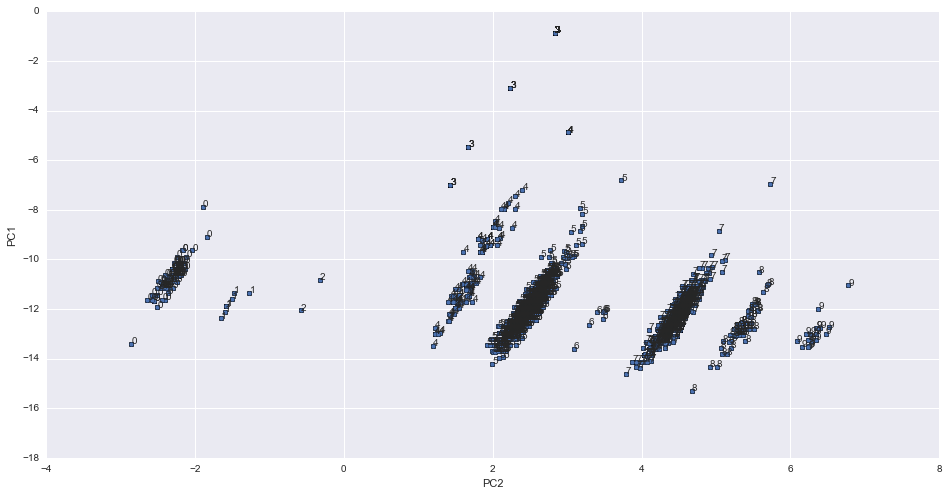

In [26]:
graph = targets_pcs.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, target in enumerate(targets_w2['HighEdCert']):
    graph.annotate(target, (targets_pcs.iloc[i].PC2, targets_pcs.iloc[i].PC1))

In [27]:
from matplotlib.mlab import PCA
#construct your numpy array of data
myData = np.array(targets_w2) 
results = PCA(myData) 

#this will return an array of variance percentages for each component
results.fracs

#this will return a 2d array of the data projected into PCA space
results.Y 

array([[ -3.10180423e+00,   8.17620622e-01,  -1.92247352e-02, ...,
          2.10359130e-01,   3.20010031e-03,   4.19155200e-04],
       [ -2.16318362e+00,  -2.69176488e-01,   4.90351873e-01, ...,
          3.65725635e-02,  -2.52170612e-02,  -4.80835777e-03],
       [ -3.28643638e+00,  -3.62259836e-01,   2.18090270e-01, ...,
         -5.15645311e-02,  -3.04759634e-02,   6.72607017e-03],
       ..., 
       [  4.78687511e+00,   2.57016767e-02,  -1.84215308e-02, ...,
         -6.70888420e-03,  -2.40310903e-03,   4.85507309e-04],
       [  4.78687511e+00,   2.57016767e-02,  -1.84215308e-02, ...,
         -6.70888420e-03,  -2.40310903e-03,   4.85507309e-04],
       [ -3.06719757e+00,   8.55757235e-01,   8.01876128e-01, ...,
         -3.37313390e-02,  -4.83456760e-02,  -7.80861687e-03]])

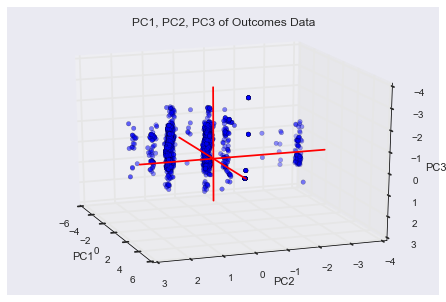

In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = []
y = []
z = []
for item in results.Y:
 x.append(item[0])
 y.append(item[1])
 z.append(item[2])

plt.close('all') # close all latent plotting windows
fig1 = plt.figure() # Make a plotting figure
ax = Axes3D(fig1) # use the plotting figure to create a Axis3D object.
pltData = [x,y,z] 
ax.scatter(pltData[0], pltData[1], pltData[2], 'bo') # make a scatter plot of blue dots from the data
 
# make simple, bare axis lines through space:
xAxisLine = ((min(pltData[0]), max(pltData[0])), (0, 0), (0,0)) # 2 points make the x-axis line at the data extrema along x-axis 
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r') # make a red line for the x-axis.
yAxisLine = ((0, 0), (min(pltData[1]), max(pltData[1])), (0,0)) # 2 points make the y-axis line at the data extrema along y-axis
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r') # make a red line for the y-axis.
zAxisLine = ((0, 0), (0,0), (min(pltData[2]), max(pltData[2]))) # 2 points make the z-axis line at the data extrema along z-axis
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r') # make a red line for the z-axis.
 
# label the axes 
ax.set_xlabel("PC1") 
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PC1, PC2, PC3 of Outcomes Data")

ax.azim = 200
ax.elev = 199


plt.show() # show the plot



# 3) PCA over target variables WITHOUT Higher Education Cert var to test...

In [29]:
# Removing HighEdCert from dataset

targets_w2_wOutHEC = targets_w2.drop('HighEdCert', axis = 1)
targets_w2_wOutHEC.columns

Index([u'PubFoodAs', u'PubHousAs', u'OthrFinAs', u'CurrFTE', u'CurrPTE',
       u'PubFinAs', u'CurrenRoll', u'PrescripIn', u'Homeless', u'SubAbuse',
       u'Incarc', u'Medicaid', u'OthrHlthIn', u'MedicalIn', u'MentlHlthIn'],
      dtype='object')

In [30]:
# y-correlations

y_corr = np.corrcoef(targets_w2_wOutHEC.values.T)
targets_w2_wOutHEC.corr()

,PubFoodAs,PubHousAs,OthrFinAs,CurrFTE,CurrPTE,PubFinAs,CurrenRoll,PrescripIn,Homeless,SubAbuse,Incarc,Medicaid,OthrHlthIn,MedicalIn,MentlHlthIn
PubFoodAs,1.000000,0.886919,0.870077,0.869874,0.856714,0.888024,0.858523,0.892729,0.872588,0.873892,0.858727,0.887538,0.868990,0.891632,0.889446
PubHousAs,0.886919,1.000000,0.895309,0.890962,0.882024,0.929199,0.894590,0.914980,0.872408,0.893191,0.872126,0.904352,0.885868,0.913547,0.913284
OthrFinAs,0.870077,0.895309,1.000000,0.924232,0.915193,0.884853,0.914356,0.941550,0.916054,0.928380,0.915808,0.929921,0.922400,0.940742,0.938488
CurrFTE,0.869874,0.890962,0.924232,1.000000,0.911457,0.883162,0.907216,0.952491,0.921979,0.932155,0.920066,0.925983,0.929696,0.953366,0.950071
CurrPTE,0.856714,0.882024,0.915193,0.911457,1.000000,0.872666,0.902568,0.933062,0.904285,0.914444,0.899056,0.917177,0.909664,0.932853,0.928115
PubFinAs,0.888024,0.929199,0.884853,0.883162,0.872666,1.000000,0.884991,0.905017,0.868806,0.883262,0.862984,0.899117,0.880122,0.902910,0.901851
CurrenRoll,0.858523,0.894590,0.914356,0.907216,0.902568,0.884991,1.000000,0.934347,0.892984,0.909427,0.894658,0.927136,0.913728,0.933575,0.930470
PrescripIn,0.892729,0.914980,0.941550,0.952491,0.933062,0.905017,0.934347,1.000000,0.935910,0.947686,0.936397,0.945660,0.956237,0.985035,0.983358
Homeless,0.872588,0.872408,0.916054,0.921979,0.904285,0.868806,0.892984,0.935910,1.000000,0.932703,0.927434,0.915469,0.918826,0.936868,0.932474
SubAbuse,0.873892,0.893191,0.928380,0.932155,0.914444,0.883262,0.909427,0.947686,0.932703,1.000000,0.943555,0.929293,0.926873,0.947917,0.944592


In [31]:
# Obtaining eigenvalues and eigenvectors for PCA

eig_vals, eig_vecs = np.linalg.eig(y_corr)
print eig_vals
print eig_vecs


[  1.38023003e+01   2.49449579e-01   1.45585656e-01   1.36127214e-02
   1.97847536e-02   1.11337589e-01   1.01886348e-01   9.42558150e-02
   5.13363258e-02   5.29305691e-02   6.29869298e-02   7.69498981e-02
   7.78608717e-02   6.77993731e-02   7.19232745e-02]
[[ -2.48048629e-01  -4.89381278e-01   6.60720186e-01  -2.69761231e-03
   -1.13089778e-02   4.63681537e-01  -3.65053740e-02   6.55955475e-02
    7.23985495e-02  -2.19509660e-02   4.65911960e-02   1.69285539e-01
    2.97577794e-02   6.48839877e-02  -2.88735027e-03]
 [ -2.53400634e-01  -4.72561008e-01  -2.35013322e-01   7.17915548e-03
   -3.88136134e-03  -3.29466199e-01   5.55883741e-03  -6.77907941e-02
    1.23094128e-01   7.99337571e-02  -2.12608967e-01   3.52423339e-01
    4.03419762e-03  -5.93878067e-01  -1.86571929e-02]
 [ -2.58914122e-01   8.96626480e-02  -8.76665761e-02  -4.49890674e-03
    6.62612658e-03   7.87799151e-05  -2.08064986e-01   1.95738450e-01
    2.52417968e-02   7.57354323e-03   3.01918146e-01   1.43513536e-01
  

In [32]:
# Obtaining cumulative explained variance

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print cum_var_exp

[ 92.0153353   93.67833249  94.64890354  95.39115413  96.07039645
  96.69876855  97.21784103  97.73084035  98.21032885  98.66232467
  99.08223753  99.43510799  99.77735017  99.90924852 100.        ]


In [33]:
# From output of cell above, we can see 
# that the first two principal components explain 93.7% of the variance in the target variables

In [34]:
# Obtaining eigenpairs...

value_vector_pairs = [[eig_vals[i], eig_vecs[:,i]] for i in range(len(eig_vals))]
value_vector_pairs.sort(reverse=True)

In [35]:
# Transforming eigen data to obtain 2d PCA projection matrix in order to plot principal components

weight_2d_projection = np.hstack((value_vector_pairs[0][1].reshape(eig_vecs.shape[1],1),
                                  value_vector_pairs[1][1].reshape(eig_vecs.shape[1],1)))

print 'Weight data 2d PCA projection matrix:\n', weight_2d_projection

Weight data 2d PCA projection matrix:
[[-0.24804863 -0.48938128]
 [-0.25340063 -0.47256101]
 [-0.25891412  0.08966265]
 [-0.25959963  0.1502853 ]
 [-0.25594364  0.1116576 ]
 [-0.25147022 -0.54391813]
 [-0.25629932 -0.00329996]
 [-0.26506968  0.10218539]
 [-0.25725502  0.20151143]
 [-0.26023678  0.17141019]
 [-0.25694606  0.26267798]
 [-0.26048236 -0.00428943]
 [-0.25957672  0.16180456]
 [-0.26497387  0.11539318]
 [-0.26413806  0.09642183]]


In [36]:
Z = targets_w2_wOutHEC.dot(weight_2d_projection)

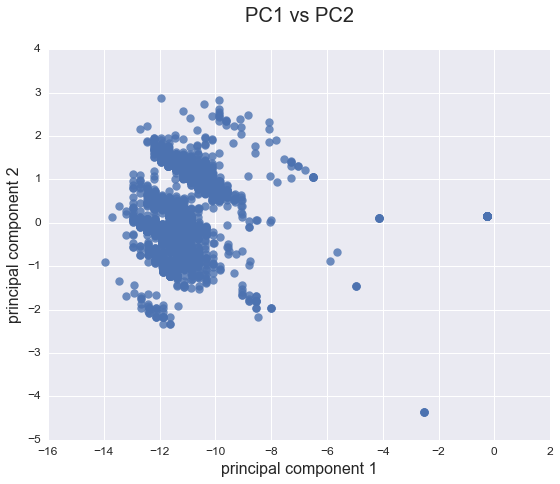

In [37]:
fig = plt.figure(figsize=(9,7))

ax = fig.gca()
ax = sns.regplot(Z.iloc[:,0], Z.iloc[:,1],
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=16)
ax.set_ylabel('principal component 2', fontsize=16)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs PC2\n', fontsize=20)

plt.show()

In [38]:
# Will now transform data so that PC1 and PC2 can be plotted with individual target variables...
# Need to do this in order to see which variables are more likely part of the principal components...

targets_22 = targets_w2_wOutHEC

targets_pcs = targets_22.copy

targets_pcs = (targets_22 - targets_22.mean()) / targets_22.std()

targets_pcs['PC1'] = Z.iloc[:,0]
targets_pcs['PC2'] = Z.iloc[:,1]


In [39]:
targets_pcs = pd.melt(targets_pcs, id_vars=['PC1','PC2'])

In [40]:
targets_pcs.head()

,PC1,PC2,variable,value
0,-11.126543,0.064901,PubFoodAs,1.551348
1,-10.112709,0.846441,PubFoodAs,0.199028
2,-11.642770,0.294177,PubFoodAs,1.551348
3,-11.382487,0.176558,PubFoodAs,1.551348
4,-11.115772,0.146204,PubFoodAs,1.551348


### PC1 vs Target Variables

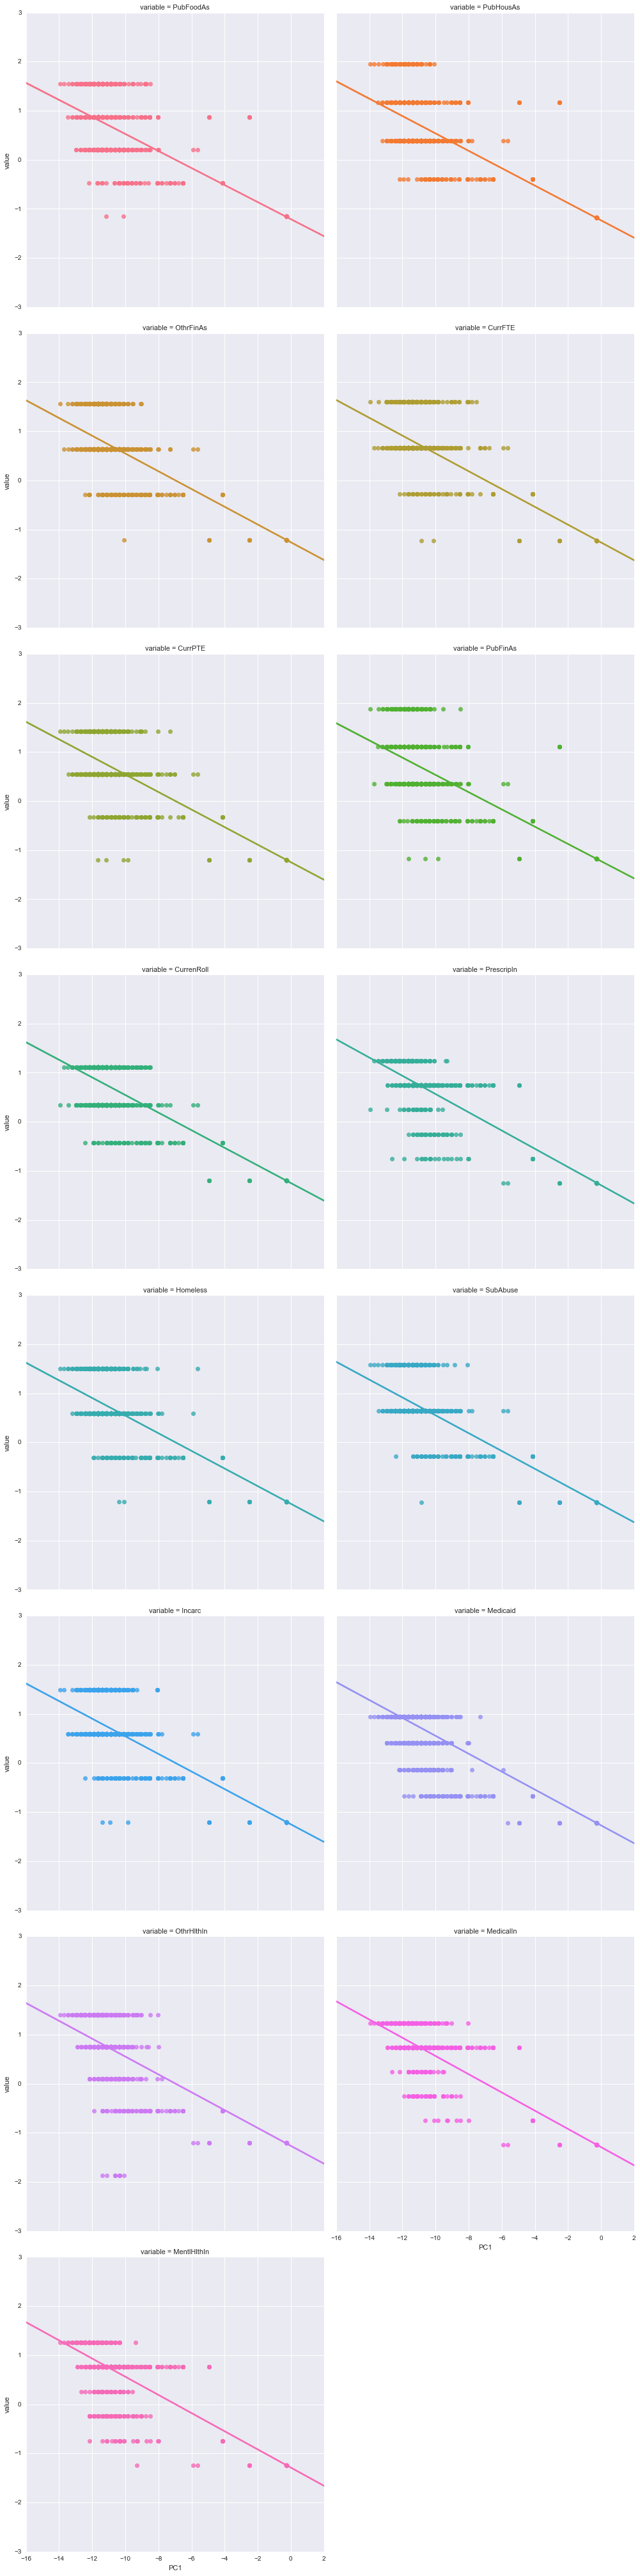

In [79]:
pc1 = sns.lmplot(x="PC1", y="value", col="variable", hue="variable", 
                 data=targets_pcs, col_wrap=2, size=7, scatter_kws={'s':50})


### PC2 vs Target Variables

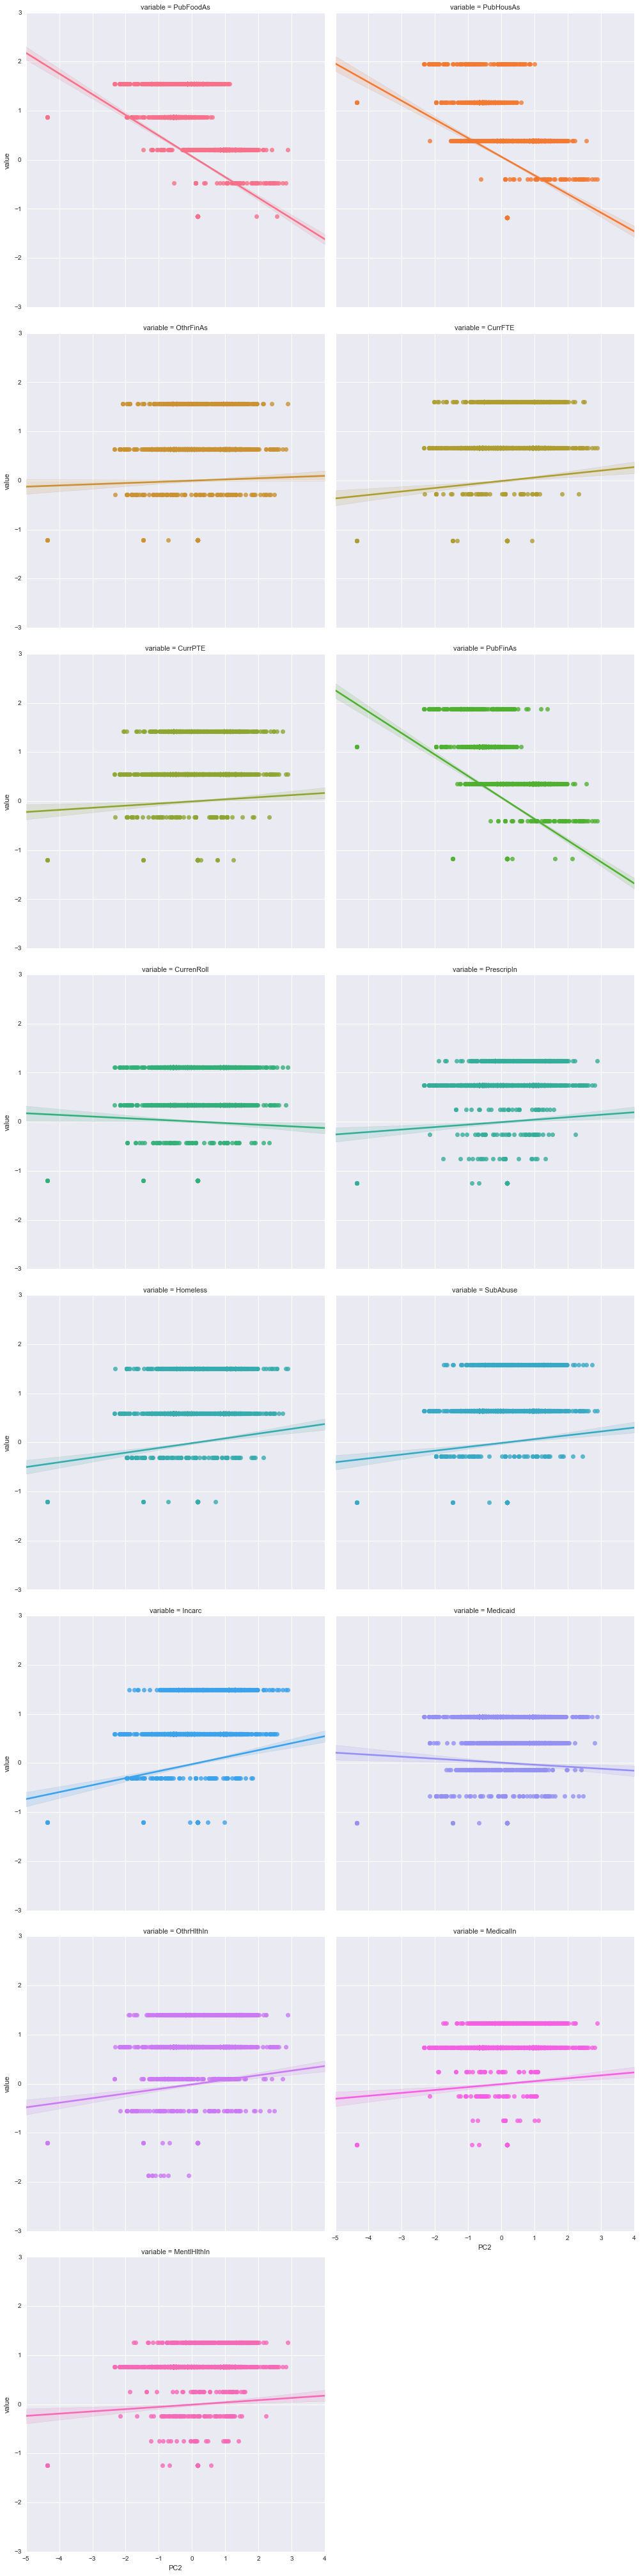

In [80]:
pc2 = sns.lmplot(x="PC2", y="value", col="variable", hue="variable", 
                 data=targets_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

### PC1 vs PC2 WITH LABELS

In [81]:
from sklearn.decomposition import PCA 

pcask = PCA(n_components=2)
print pcask.fit(targets_w2_wOutHEC).components_ # See the eigenvectors
yPC = pcask.fit_transform(targets_w2_wOutHEC) # Use the eigenvectors to transform xStand onto new axes

PCdf = pd.DataFrame(yPC, columns=['PC1','PC2'])

targets_22 = targets_w2_wOutHEC

target_pca = targets_22.join(PCdf, on=None, how='left')



[[-0.24830261 -0.21830428 -0.18903304 -0.18600185 -0.19749825 -0.22353602
  -0.2249894  -0.36161844 -0.19260192 -0.18814882 -0.19286694 -0.32752826
  -0.27036371 -0.36283222 -0.35816922]
 [-0.65174392 -0.37813123  0.03426175  0.0911183   0.06037737 -0.47146446
   0.01159313  0.20632404  0.07452681  0.07079049  0.12565163 -0.05354636
   0.19508492  0.21951594  0.19666115]]


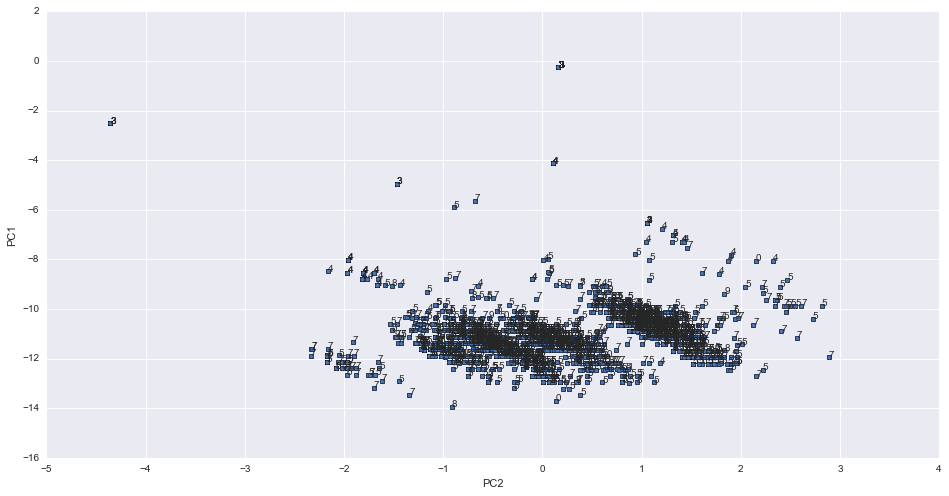

In [82]:
graph = targets_pcs.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, target in enumerate(targets_w2['HighEdCert']):
    graph.annotate(target, (targets_pcs.iloc[i].PC2, targets_pcs.iloc[i].PC1))

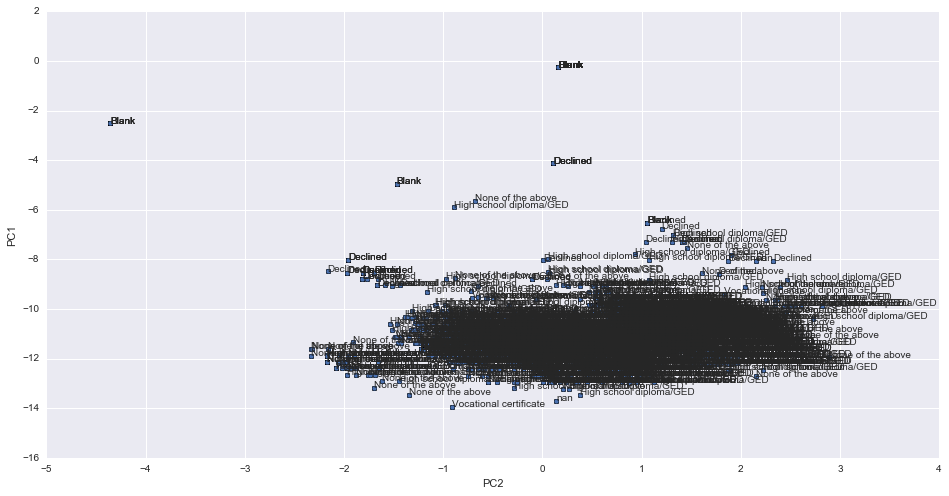

In [83]:
graph = targets_pcs.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, target in enumerate(targets_w2_['HighEdCert']):
    graph.annotate(target, (targets_pcs.iloc[i].PC2, targets_pcs.iloc[i].PC1))


In [84]:
from matplotlib.mlab import PCA
#construct your numpy array of data
myData = np.array(targets_w2_wOutHEC) 
results = PCA(myData) 

#this will return an array of variance percentages for each component
results.fracs

#this will return a 2d array of the data projected into PCA space
results.Y 


array([[ -2.87458551e+00,   8.75316865e-04,  -1.10534084e+00, ...,
         -2.18155848e-01,  -1.27248894e-03,   1.83006621e-03],
       [ -2.16663303e+00,   4.83432320e-01,   5.36206971e-02, ...,
         -3.75608855e-02,   2.49195013e-02,  -5.05326395e-03],
       [ -3.31431383e+00,   2.12849494e-01,  -8.49326393e-01, ...,
          6.48754876e-02,   2.77421568e-02,   4.82257808e-03],
       ..., 
       [  4.68756738e+00,  -1.80659089e-02,  -1.77905764e-03, ...,
          6.75238291e-03,   2.39389425e-03,   4.76724750e-04],
       [  4.68756738e+00,  -1.80659089e-02,  -1.77905764e-03, ...,
          6.75238291e-03,   2.39389425e-03,   4.76724750e-04],
       [ -2.83907608e+00,   8.22495457e-01,  -8.54864566e-02, ...,
          2.36917623e-02,   4.98489372e-02,  -6.69829227e-03]])

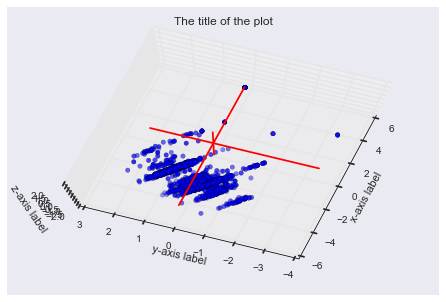

In [88]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = []
y = []
z = []
for item in results.Y:
 x.append(item[0])
 y.append(item[1])
 z.append(item[2])

plt.close('all') # close all latent plotting windows
fig1 = plt.figure() # Make a plotting figure
ax = Axes3D(fig1) # use the plotting figure to create a Axis3D object.
pltData = [x,y,z] 
ax.scatter(pltData[0], pltData[1], pltData[2], 'bo') # make a scatter plot of blue dots from the data
 
# make simple, bare axis lines through space:
xAxisLine = ((min(pltData[0]), max(pltData[0])), (0, 0), (0,0)) # 2 points make the x-axis line at the data extrema along x-axis 
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r') # make a red line for the x-axis.
yAxisLine = ((0, 0), (min(pltData[1]), max(pltData[1])), (0,0)) # 2 points make the y-axis line at the data extrema along y-axis
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r') # make a red line for the y-axis.
zAxisLine = ((0, 0), (0,0), (min(pltData[2]), max(pltData[2]))) # 2 points make the z-axis line at the data extrema along z-axis
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r') # make a red line for the z-axis.
 
# label the axes 
ax.set_xlabel("x-axis label") 
ax.set_ylabel("y-axis label")
ax.set_zlabel("z-axis label")
ax.set_title("The title of the plot")

ax.azim = 200
ax.elev = 80


plt.show() # show the plot